# Train and Deploy K-Mean Model  


### Introduction
Welcome to our end-to-end K-Mean training notebook. In this notebook, we train and deploy a K-Mean model using LLM vectors proved by `Bedrock Titan Embeddings G1 – Text model` to get vector embedding for all the tables that tthe dataloader labda stored in opensearch raw index. After model training the notebook deploy the trained model to a serverless inference to provide Labeling serivce endpoint for table clustering. 

In this demo we are using Sagemaker built in models library. Find more details at the following URL: https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html#algorithms-built-in-supervised-learning

#### Pre-requisites
Please make sure you run the following CDK Stacked before start this notebook:
- 01. RolesStack Deployment - Main & Secondary accounts
- 02. SearchContentStack Deployment - Main account only
- 04. DataLoadStack Deployment - Main & Secondary accounts

Run the OpenSearchDataload Lambda function in each account where it deployed to collect the right amount of data to allows your K-Mean model to achieve the desired level of accuracy! 

For data access control, we are using Principle of Least Privilege approach so the follwoing pre-requisites need to be configured at Opensearch serverless Data access policies:

 `search-admin-access-policy` must have SageMaker execution role included as selected principal. e.g.:
 
     arn:aws:sts::<accountid>:assumed-role/AmazonSageMakerServiceCatalogProductsUseRole/SageMaker 
    
 `vectorsearch-admin-access-policy` must have SageMaker execution role included as selected principal e.g.:. 
 
     arn:aws:sts::<accountid>:assumed-role/AmazonSageMakerServiceCatalogProductsUseRole/SageMaker 
     
#### Post Jupiter Notebook actions

Please make sure you save the `K-Mean endpoint name` after the K-mean model deployment and use that attribure for the `03. LambdasStack Deployment - Main account only` CDK Stack deployment.

### Install Python packages

In [ ]:
!pip install opensearch-py
!pip install --upgrade pandas 
!pip install requests_aws4auth

In [ ]:
import os
import boto3
import sagemaker
import pandas as pd
import numpy as np
import time
import warnings
import json
import hashlib
from datetime import datetime
from botocore.exceptions import ClientError
import requests
from opensearchpy import AWSV4SignerAuth
from opensearchpy import OpenSearch, RequestsHttpConnection

warnings.filterwarnings('ignore')

### Read Training Data from Opensearch

#### Create OpenSearch Connection 

In [ ]:
# Replace with the ARN of the IAM role to assume
role_arn = "arn:aws:iam::<accountID>:role/searchadmin-searchable-contentNormal"
vector_collecion_role_arn = "arn:aws:iam::<accountID>:role/vectorsearchadmin-searchable-contentNormal"

# Replace with your OpenSearch Collections endpoints
search_host = "<search collection endpoint>" # Exclude the leading "https://"
vector_host = "<vector collection endpoint>" # Exclude the leading "https://"

#Replace with the ExternalId
AssumeRoleExternalId="<The External ID that has been set by the CDK>"

#SageMaker training output bucket
bucket = "<bucket name for model training>"

In [ ]:
import boto3
import botocore
from requests_aws4auth import AWS4Auth

region = 'us-east-1'
service = 'aoss'

# Create an STS client
sts_client = boto3.client("sts")

# ========== Search Collection temp credentials ==========
# Call the assume_role method of the STSConnection object and pass the role ARN
assumed_role = sts_client.assume_role(
    RoleArn=role_arn,
    RoleSessionName="AssumeRoleSession1",
    ExternalId=AssumeRoleExternalId
)

# From the response that contains the assumed role, get the temporary credentials
temp_credentials = assumed_role["Credentials"]

awsauth = AWS4Auth(temp_credentials['AccessKeyId'],temp_credentials['SecretAccessKey'], region, service,session_token=temp_credentials['SessionToken'])

# ========= Vector Collection temp credentials =========
# Call the assume_role method of the STSConnection object and pass the role ARN
v_assumed_role = sts_client.assume_role(
    RoleArn=vector_collecion_role_arn,
    RoleSessionName="AssumeRoleSession1",
    ExternalId=AssumeRoleExternalId
)

# From the response that contains the assumed role, get the temporary credentials
v_temp_credentials = v_assumed_role["Credentials"]

v_awsauth = AWS4Auth(v_temp_credentials['AccessKeyId'],v_temp_credentials['SecretAccessKey'], region, service,session_token=v_temp_credentials['SessionToken'])



port = 443

# Create the client with SSL/TLS enabled, but hostname verification disabled.
searchclient = OpenSearch(
    hosts = [{'host': search_host, 'port': port}],
    http_auth = awsauth,
    timeout = 100,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    use_ssl = True
)

vectorclient = OpenSearch(
    hosts = [{'host': vector_host, 'port': port}],
    http_auth = v_awsauth,
    timeout = 100,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    use_ssl = True
)

#### Get all the raw index records

In [ ]:
result_dict = searchclient.search(index="raw", body={"query": {"match_all": {}}})

from pandas import json_normalize
# from pandas.io.json import json_normalize
df_all = json_normalize(result_dict['hits']['hits'])
df_all

### Generate vector embeddign 
using Bedrock Titan Embedding G1-Text

In [ ]:
def bedrock_sentence_to_vector(raw_inputs):
    print("raw_input_len:", len(raw_inputs))
    vectors = [] 
    bedrock_runtime = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-east-1'  # Replace with your desired region
    )
    
    for column in raw_inputs:
        #print ("column Name:",column)
        body = json.dumps({"inputText": column})
            # The actual call to retrieve a response from the model
        response = bedrock_runtime.invoke_model(
           body=body,
           modelId="amazon.titan-embed-text-v1",  # Replace with your model ID
           accept='application/json',
           contentType='application/json'
        )
        response_body = json.loads(response.get('body').read())
        vectors.append(response_body['embedding'])
    return (vectors)

In [ ]:
bedrock_vector_sentences = bedrock_sentence_to_vector(df_all["_source.columns"].tolist())
print(len(bedrock_vector_sentences)," vector embeddings created")
#print (bedrock_vector_sentences[0])

df_all["columns_vector"] = bedrock_vector_sentences

### Train K-Means model to find similar items using vectors

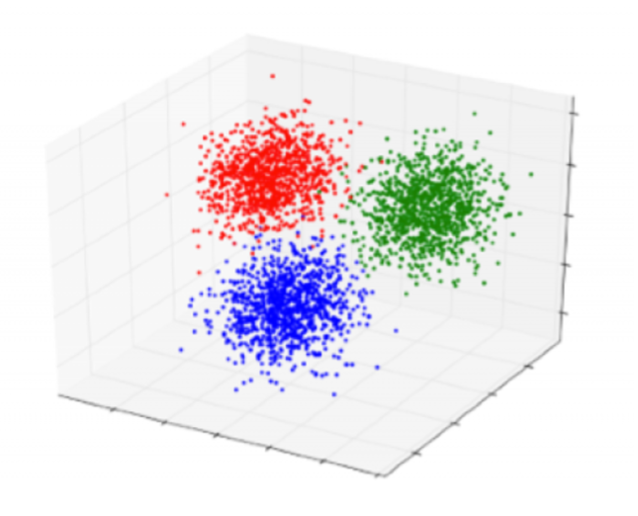

Deppending on the number of tables your organization have, tune the `num_clusters` variable to find the optimal number of clusters that drive the poligon size (size of the colored clusers on the diagram). This is an iterative aproach.

In [ ]:
from sagemaker import KMeans
from sagemaker import get_execution_role

# Set number of clusters you want to group your data points into.
num_clusters = 3

role =  get_execution_role()

kmeans = KMeans(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path="s3://" + bucket + "/k-means/",
    k=num_clusters,
)

kmeans.fit(kmeans.record_set(np.float32(np.array(bedrock_vector_sentences))))

#### Deploy the K-Mean model to a serverless inference

In [ ]:
from sagemaker.serverless import ServerlessInferenceConfig
serverless_config = ServerlessInferenceConfig()

serverless_config = ServerlessInferenceConfig(
  memory_size_in_mb=4096,
  max_concurrency=2,
)

serverless_kmean = kmeans.deploy(serverless_inference_config=serverless_config)

In [ ]:
print('Please save the deployed inference endpoint name and use it as the input for deltasqs2enreachment config !!! ')
print('K-Mean endpoint name:',serverless_kmean.endpoint_name)

#### Predict K-Means Labels for the tables

In [ ]:
train_data = np.float32(np.array(bedrock_vector_sentences))
result = serverless_kmean.predict(train_data)

cluster_labels = [r.label["closest_cluster"].float32_tensor.values[0] for r in result]
np.int32(cluster_labels)

df_all['K-meanLabel'] = np.int32(cluster_labels).tolist()

df_all

### Save the embedded records to OpenSearch Vector index


In [ ]:
df_out = df_all.drop(columns=['_index','_score'])

# map the colums to the destination schema
df_out.rename(columns = {'_id':'id_search', 
                         '_source.CollectTime':'CollectTime',
                         '_source.accountid':'accountid',
                         '_source.region':'region',
                         '_source.tablename':'tablename',
                         '_source.columns':'columns',
                         '_source.databasename':'databasename',
                         '_source.location':'location',
                         '_source.owner':'owner',
                         '_source.CreateTime':'CreateTime',
                         '_source.UpdateTime':'UpdateTime'
                         }, inplace = True)

# Save the records to Opensearch Vector index
records = df_out.to_dict(orient='records')
for record in records:
    vectorclient.index(index='fultable_dedup', body=record)
